In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv('home-data-for-ml-course/train.csv')
X_test = pd.read_csv('home-data-for-ml-course/test.csv')

In [3]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
dict = {}
for col in X.columns:
    dict[col] = X[col].isnull().sum() / X.shape[0]
cols_to_drop = [k for k, v in dict.items() if v > 0.4]
print(cols_to_drop)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
# X = X.drop(cols_to_drop, axis=1)
# X_test = X_test.drop(cols_to_drop, axis=1)
y = X.SalePrice
X = X.drop('SalePrice', axis=1)

outliners = X[(X['GrLivArea'] > 4000) & (y < 300000)].index
# X = X.drop(outliners, axis=1)
# X_test = X_test.drop(outliners, axis=1)

In [8]:
object_cols_OH = ['MSZoning', 'Street', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                          'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition',
                 'MiscFeature', 'MasVnrType', 'Alley']

object_cols_Ordinal = ['Utilities', 'LandContour', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'FireplaceQu', 'PoolQC',
                       'Fence']

object_cols_Target = ['Neighborhood', 'Exterior1st', 'Exterior2nd']
X['MSSubClass'] = X['MSSubClass'].astype(str)
X_test['MSSubClass'] = X_test['MSSubClass'].astype(str)
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
print(num_cols)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [20]:
time_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
non_time_cols = list(set(num_cols) - set(time_cols))
print(non_time_cols)

['BsmtFinSF1', 'LowQualFinSF', 'MasVnrArea', 'PoolArea', 'BedroomAbvGr', 'FullBath', 'ScreenPorch', 'OverallCond', 'WoodDeckSF', 'OverallQual', '1stFlrSF', '3SsnPorch', 'GrLivArea', 'LotArea', 'Fireplaces', 'OpenPorchSF', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFullBath', 'Id', 'GarageArea', 'BsmtFinSF2', 'KitchenAbvGr', 'LotFrontage', 'EnclosedPorch', 'MiscVal', 'HalfBath', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd']


In [21]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
imputer_num_time = SimpleImputer(strategy='median')
imputer_num_non_time = SimpleImputer(strategy='constant', fill_value=0)
imputer_cat = SimpleImputer(strategy='constant', fill_value='NA')

In [22]:
utility_levels = ['NA', 'ELO', 'NoSeWa', 'NoSewr', 'AllPub']
shape_levels = ['IR3', 'IR2', 'IR1', 'Reg']
countour_levels = ['Low', 'HLS', 'Bnk', 'Lvl']
slope_levels = ['Sev', 'Mod', 'Gtl']
qual_cond_levels = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
explosure_levels = ['NA', 'No', 'Mn', 'Av', 'Gd']
fin_levels = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
func_levels = ['NA', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
gar_fnsh_levels = ['NA', 'Unf', 'RFn', 'Fin']
pave_levels = ['N', 'P', 'Y']
fence_levels = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

In [24]:
num_non_time_transformer = Pipeline(steps=[
    ('imputer', imputer_num_non_time),
    ('scaler', StandardScaler())
])
num_time_transformer = Pipeline(steps=[
    ('imputer', imputer_num_time),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('onehot', OH_encoder)
])
target_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('target', TargetEncoder())
])
ord_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('ordinal', OrdinalEncoder(categories=[utility_levels, countour_levels, shape_levels, slope_levels, qual_cond_levels, qual_cond_levels, 
                                           qual_cond_levels, qual_cond_levels, explosure_levels, fin_levels, fin_levels, qual_cond_levels,
                                           qual_cond_levels, func_levels, gar_fnsh_levels, qual_cond_levels, qual_cond_levels, pave_levels,
                                           qual_cond_levels, qual_cond_levels, fence_levels]))
])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('time', num_time_transformer, time_cols),
        ('non_time', num_non_time_transformer, non_time_cols),
        ('cat', cat_transformer, object_cols_OH),
        ('target', target_transformer, object_cols_Target),
        ('ord', ord_transformer, object_cols_Ordinal)
    ]
)

In [27]:
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, verbose=-1)
# model_lasso = LassoCV(max_iter=10000)

stacking_model = StackingRegressor(
    estimators=[
        ('xgb', model_xgb),
        ('lgbm', model_lgbm)
    ],
    final_estimator=RidgeCV()
)

In [28]:
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

In [29]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -1 * cross_val_score(my_pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')

In [30]:
print(scores.mean())

15823.305569409666


In [31]:
my_pipeline.fit(X, y)

predictions = my_pipeline.predict(X_test)
print(predictions)

[126104.94582849 158950.57297691 189941.77343817 ... 162489.79450594
 113228.7151761  187496.2988162 ]


In [33]:
output = pd.DataFrame({'Id': X_test['Id'],
                       'SalePrice': predictions})
output.to_csv('home-data-for-ml-course/submission.csv', index=False)

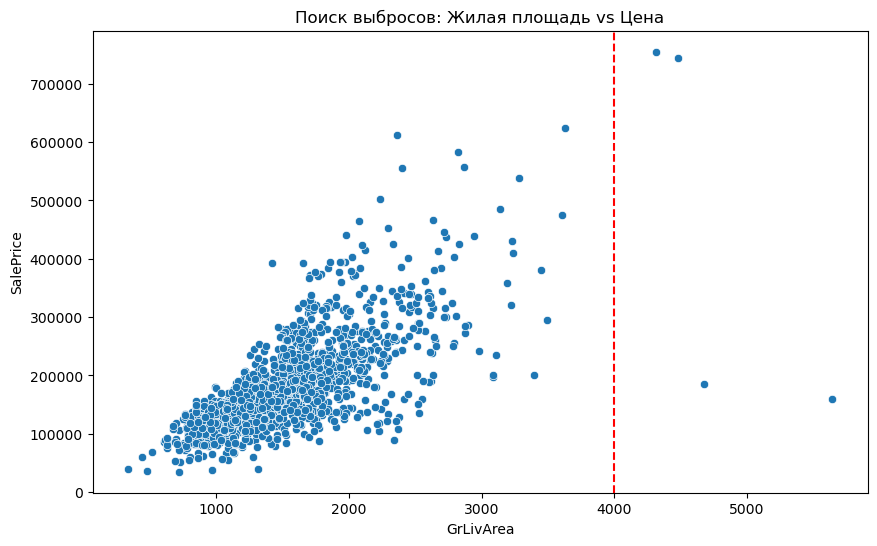

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pd.concat([X['GrLivArea'], y], axis=1), x='GrLivArea', y='SalePrice')
plt.title('Поиск выбросов: Жилая площадь vs Цена')
plt.axvline(x=4000, color='r', linestyle='--') # Линия отсечки
plt.show()